In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import random

In [6]:
DATA_FOLDER_PATH = "../"

INPUT_DIR = DATA_FOLDER_PATH + "00_archive/data_samples/" # TODO set this to the correct path
OUTPUT_DIR = DATA_FOLDER_PATH + "00_archive/data_samples_processed/"
file_types = ["train", "test", "val"]
subdirectories = ["Coccidiosis", "Healthy", "New Castle Disease", "Salmonella"]

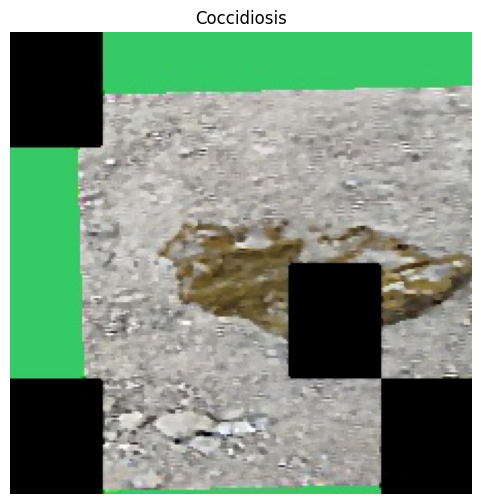

In [7]:
subdir_path = os.path.join(INPUT_DIR, file_types[0])
subsubdir_path = os.path.join(subdir_path, subdirectories[0])
files = os.listdir(subsubdir_path)
random_file = random.choice(files)
img_path = os.path.join(subsubdir_path, random_file)
img = Image.open(img_path)
# display the random image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(subdirectories[0])
plt.axis('off')
plt.show()

## Which features are most important for predicting the target variable?

### Features Extracted:

1. **Color Histograms (HSV)**

   * Captures distribution of colors, which may indicate bile, blood, or dehydration.
2. **Texture (Local Binary Patterns - LBP)**

   * Describes local texture to distinguish between smooth, grainy, or fibrous stool.
3. **Edges (Canny edge detection)**

   * Highlights structure and fragmentation.
4. **Keypoints (SIFT)**

   * Captures distinctive visual patterns and texture.
5. **Simple Statistics**

   * Mean, standard deviation, skewness, entropy, etc.

### Workflow:

* Load image
* Convert to grayscale + HSV
* Extract features per image
* Store results in a Pandas DataFrame


In [4]:
img_path

'../00_archive/data_samples/train\\Coccidiosis\\cocci.1349.jpg_aug8.JPG'

In [5]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy.stats import skew
from tqdm import tqdm

# Parameters for LBP
LBP_RADIUS = 1
LBP_POINTS = 8

# Parameters for HSV histogram
HSV_BINS = [50, 60, 60]  # H, S, V bin counts
HSV_RANGES = [ [0, 180], [0, 256], [0, 256] ]

# Initialize SIFT (or use ORB if SIFT unavailable)
sift = cv2.SIFT_create()

def extract_features(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    # Resize image for consistency (optional)
    image = cv2.resize(image, (256, 256))
    
    # Convert to grayscale and HSV
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    features = {}

    # --- 1. HSV Histogram ---
    for i, (bins, rng) in enumerate(zip(HSV_BINS, HSV_RANGES)):
        hist = cv2.calcHist([hsv], [i], None, [bins], rng)
        hist = cv2.normalize(hist, hist).flatten()
        features.update({f'hsv_{i}_{j}': val for j, val in enumerate(hist)})

    # --- 2. LBP Texture ---
    lbp = local_binary_pattern(gray, P=LBP_POINTS, R=LBP_RADIUS, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, LBP_POINTS + 3),
                                 range=(0, LBP_POINTS + 2))
    lbp_hist = lbp_hist.astype("float") / (lbp_hist.sum() + 1e-6)
    features.update({f'lbp_{i}': val for i, val in enumerate(lbp_hist)})

    # --- 3. Edge Pixels (Canny) ---
    edges = cv2.Canny(gray, 100, 200)
    edge_ratio = np.sum(edges > 0) / (gray.shape[0] * gray.shape[1])
    features['edge_ratio'] = edge_ratio

    # --- 4. SIFT Keypoint Count ---
    keypoints, _ = sift.detectAndCompute(gray, None)
    features['sift_keypoints'] = len(keypoints)

    # --- 5. Basic Statistics ---
    features['mean_intensity'] = np.mean(gray)
    features['std_intensity'] = np.std(gray)
    features['skew_intensity'] = skew(gray.flatten())
    features['entropy'] = np.mean(entropy(gray, disk(5)))

    return features

# # Process all images in a folder
def process_image_folder(folder_path, target):
    data = []
    filenames = []
    for file in tqdm(os.listdir(folder_path)):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder_path, file)
            feats = extract_features(path)
            if feats is not None:
                data.append(feats)
                filenames.append(file)
                data[-1]['target'] = target
    
    df = pd.DataFrame(data)
    df['filename'] = filenames
    return df

# Example usage
#df_features = process_image_folder(subsubdir_path)



KeyboardInterrupt: 

In [ ]:
for file_type in file_types:
    for subdir in subdirectories:
        subdir_path = os.path.join(INPUT_DIR, file_type, subdir)
        if os.path.exists(subdir_path):
            df = process_image_folder(subdir_path, subdir)
            print(f"Processed {file_type} - {subdir}: {len(df)} images")
            output_file = os.path.join(OUTPUT_DIR, f"{file_type}")
            try:
                os.makedirs(output_file, exist_ok=True)
            except Exception as e:
                print(f"Error creating output directory: {e}")

            output_file = os.path.join(output_file, f"{subdir}.csv")
            df.to_csv(output_file, index=False)
            print(f"Saved features to {output_file}")


100%|██████████| 1000/1000 [01:17<00:00, 12.96it/s]


Processed train - Coccidiosis: 1000 images
Saved features to ../00_archive/data_samples_processed/train\Coccidiosis.csv


100%|██████████| 1000/1000 [01:16<00:00, 13.09it/s]


Processed train - Healthy: 1000 images
Saved features to ../00_archive/data_samples_processed/train\Healthy.csv


100%|██████████| 994/994 [01:26<00:00, 11.50it/s]


Processed train - New Castle Disease: 994 images
Saved features to ../00_archive/data_samples_processed/train\New Castle Disease.csv


100%|██████████| 999/999 [01:23<00:00, 11.95it/s]


Processed train - Salmonella: 999 images
Saved features to ../00_archive/data_samples_processed/train\Salmonella.csv


100%|██████████| 1000/1000 [01:20<00:00, 12.38it/s]


Processed test - Coccidiosis: 1000 images
Saved features to ../00_archive/data_samples_processed/test\Coccidiosis.csv


100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s]


Processed test - Healthy: 1000 images
Saved features to ../00_archive/data_samples_processed/test\Healthy.csv


100%|██████████| 996/996 [01:23<00:00, 11.96it/s]


Processed test - New Castle Disease: 996 images
Saved features to ../00_archive/data_samples_processed/test\New Castle Disease.csv


100%|██████████| 994/994 [01:17<00:00, 12.80it/s]


Processed test - Salmonella: 994 images
Saved features to ../00_archive/data_samples_processed/test\Salmonella.csv


100%|██████████| 1000/1000 [01:17<00:00, 12.87it/s]


Processed val - Coccidiosis: 1000 images
Saved features to ../00_archive/data_samples_processed/val\Coccidiosis.csv


100%|██████████| 1000/1000 [01:07<00:00, 14.78it/s]


Processed val - Healthy: 1000 images
Saved features to ../00_archive/data_samples_processed/val\Healthy.csv


100%|██████████| 996/996 [01:23<00:00, 11.96it/s]


Processed val - New Castle Disease: 996 images
Saved features to ../00_archive/data_samples_processed/val\New Castle Disease.csv


100%|██████████| 1000/1000 [01:22<00:00, 12.14it/s]


Processed val - Salmonella: 1000 images
Saved features to ../00_archive/data_samples_processed/val\Salmonella.csv


🔹 1. Random Forest (RF)
Pourquoi ?

Robuste aux données bruitées (ex. histogrammes irréguliers, variations de texture).

Gère bien les relations non linéaires entre les features (HSV, LBP, etc.).

Donne une importance des variables — utile pour interpréter les descripteurs les plus discriminants.

Quand l’utiliser ?

Pour un bon point de départ.

Si tu veux interpréter l’impact de chaque feature (via feature_importances_).

🔹 2. Support Vector Machine (SVM)
Pourquoi ?

Très efficace en classification binaire ou multi-classe (via One-vs-One ou One-vs-Rest).

Très bon pour des jeux avec peu de bruit et des features bien séparés.

Peut utiliser des kernels (linéaire, RBF) pour capter des séparations non linéaires.

Quand l’utiliser ?

Si tes features sont bien normalisés (ce qui semble être le cas).

Pour comparer la performance avec RF.

🔹 3. XGBoost (ou LightGBM)
Pourquoi ?

Modèle de gradient boosting très performant en tabulaire.

Excellente capacité à gérer l’interaction complexe entre les descripteurs.

Très efficace même avec peu de tuning.

Quand l’utiliser ?

Si tu veux chercher une meilleure précision au prix d’un peu plus de complexité.

En compétition ou en pipeline de production.

🔹 4. K-Nearest Neighbors (KNN)
Pourquoi ?

Méthode simple mais puissante, surtout si les features sont discriminants.

Pas d'entraînement nécessaire : rapide à tester.

Quand l’utiliser ?

Pour un baseline simple.

Peut révéler si certaines classes se chevauchent trop dans l’espace des features.

🔹 5. Logistic Regression (Multinomial)
Pourquoi ?

Interprétable, rapide à entraîner.

Bon benchmark pour voir si une séparation linéaire suffit.

Quand l’utiliser ?

Pour valider rapidement les performances avec un modèle simple.

Comme référence contre les modèles plus complexes.

🔹 6. MLP (Perceptron Multi-couche)
Pourquoi ?

Capable d’apprendre des relations complexes.

S’adapte bien à des features non linéaires.

Quand l’utiliser ?

Si tu veux t'approcher d’un réseau de neurones classique sans passer par CNN.

À tester surtout si RF/XGBoost plafonnent.

| Modèle        | Avantages principaux                  | Inconvénients potentiels            |
| ------------- | ------------------------------------- | ----------------------------------- |
| Random Forest | Robuste, interprétable, peu de tuning | Moins bon si features très corrélés |
| SVM           | Précis, théoriquement fondé           | Lourd si beaucoup d’échantillons    |
| XGBoost       | Très performant en général            | Plus complexe, risque d’overfit     |
| KNN           | Simple, rapide à tester               | Lourd si grand jeu de test          |
| LogReg        | Baseline clair, interprétable         | Mauvais si séparation non linéaire  |
| MLP           | Apprentissage plus profond            | Besoin d’un peu plus de tuning      |


In [1]:
import wandb
wandb.login()


wandb: Currently logged in as: yanncomor (yanncomor-utbm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [2]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns

# Chemin vers le dossier contenant les sous-dossiers train/test/val
input_root = "../00_archive/data_samples_processed"

# Chargement et concaténation de tous les fichiers CSV
def load_split(split):
    dfs = []
    split_path = os.path.join(input_root, split)
    for csv_file in os.listdir(split_path):
        if csv_file.endswith('.csv'):
            df = pd.read_csv(os.path.join(split_path, csv_file))
            dfs.append(df)
    df_split = pd.concat(dfs, ignore_index=True)
    df_split['target'] = df_split['target'].astype('category')
    df_split['target_code'] = df_split['target'].cat.codes
    return df_split





In [9]:
df_train.head()

,hsv_0_0,hsv_0_1,hsv_0_2,hsv_0_3,hsv_0_4,hsv_0_5,hsv_0_6,hsv_0_7,hsv_0_8,hsv_0_9,...,lbp_9,edge_ratio,sift_keypoints,mean_intensity,std_intensity,skew_intensity,entropy,target,filename,target_code
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000168,...,0.044571,0.016449,139,164.127945,44.197468,-1.109869,4.609767,Coccidiosis,cocci.1268.jpg_aug21.JPG,0
1,0.000190,0.000975,0.013916,0.237035,0.601753,0.743433,0.169675,0.005252,0.001652,0.000352,...,0.090408,0.186722,1206,183.875107,32.036783,-0.594470,5.143844,Coccidiosis,cocci.318.jpg_aug23.JPG,0
2,0.000590,0.002769,0.007671,0.060028,0.415929,0.902326,0.095591,0.001929,0.000431,0.000045,...,0.045807,0.118103,954,153.960037,48.001773,-0.936920,5.090181,Coccidiosis,cocci.965.jpg_aug18.JPG,0
3,0.003407,0.001799,0.003943,0.023161,0.076527,0.415596,0.725033,0.316137,0.347797,0.224412,...,0.070862,0.032532,379,173.555023,25.994865,-0.608303,4.620004,Coccidiosis,cocci.914.jpg_aug33.JPG,0
4,0.216977,0.625593,0.406721,0.612222,0.137502,0.035667,0.012619,0.000719,0.013436,0.000523,...,0.066147,0.138107,1044,173.428360,28.398581,-0.141261,5.046705,Coccidiosis,cocci.943.jpg_aug5.JPG,0


In [3]:
# Charger les splits
df_train = load_split('train')
df_test = load_split('test')

# Features et cibles
X_train = df_train.drop(columns=['target', 'target_code', 'filename'])
y_train = df_train['target_code']
X_test = df_test.drop(columns=['target', 'target_code', 'filename'])
y_test = df_test['target_code']

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Définition des modèles
models = {
    'RandomForest': RandomForestClassifier(n_estimators=400, class_weight='balanced_subsample', random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    #'LogisticRegression': LogisticRegression(multi_class='multinomial', max_iter=1000),
    #'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

base_steps = [
    ('imputer', SimpleImputer(strategy='median')),   # ou 'mean', voire KNNImputer
    ('scaler',  StandardScaler())
]

pipelines = {
    name: Pipeline(base_steps + [('model', model)])
    for name, model in models.items()
}

# Entraînement et évaluation
results = {}
for name, pipe in pipelines.items():
    wandb.init(project="DS50", name=name, reinit=True)

    pipe.fit(X_train, y_train)        # plus besoin de scaler à la main
    y_pred = pipe.predict(X_test)

    print(f"\n--- {name} ---")

    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(conf_matrix)

    wandb.log({
        "precision_macro": report['macro avg']['precision'],
        "recall_macro": report['macro avg']['recall'],
        "f1_macro": report['macro avg']['f1-score'],
        "accuracy": report['accuracy']
    })

    fig = plt.figure()
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    wandb.log({"confusion_matrix": wandb.Image(fig)})
    plt.close(fig)

    wandb.finish()

    results[name] = {
        "report": report,
        "confusion_matrix": conf_matrix
    }



accuracy,▁
f1_macro,▁
precision_macro,▁
recall_macro,▁
accuracy,0.73775
f1_macro,0.73799
precision_macro,0.73988
recall_macro,0.73775



--- RandomForest ---
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2000
           1       0.70      0.76      0.73      2000
           2       0.68      0.68      0.68      2000
           3       0.79      0.71      0.75      2000

    accuracy                           0.74      8000
   macro avg       0.74      0.74      0.74      8000
weighted avg       0.74      0.74      0.74      8000

Confusion Matrix:
[[1588  121  185  106]
 [ 102 1520  248  130]
 [ 189  307 1368  136]
 [ 142  217  215 1426]]


accuracy,▁
f1_macro,▁
precision_macro,▁
recall_macro,▁
accuracy,0.73775
f1_macro,0.73799
precision_macro,0.73988
recall_macro,0.73775



--- SVM ---
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2000
           1       0.66      0.74      0.70      2000
           2       0.63      0.65      0.64      2000
           3       0.75      0.64      0.69      2000

    accuracy                           0.69      8000
   macro avg       0.70      0.69      0.70      8000
weighted avg       0.70      0.69      0.70      8000

Confusion Matrix:
[[1493  144  229  134]
 [ 104 1489  271  136]
 [ 207  337 1296  160]
 [ 175  273  271 1281]]


accuracy,▁
f1_macro,▁
precision_macro,▁
recall_macro,▁
accuracy,0.69488
f1_macro,0.695
precision_macro,0.69849
recall_macro,0.69488


d:\UTBM\INFO4\07_DS50\DS50_project\venvProjetDS50\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "d:\UTBM\INFO4\07_DS50\DS50_project\venvProjetDS50\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\yannc\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yannc\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1039, in __init__
  


--- KNN ---
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      2000
           1       0.64      0.64      0.64      2000
           2       0.54      0.64      0.59      2000
           3       0.71      0.56      0.62      2000

    accuracy                           0.64      8000
   macro avg       0.64      0.64      0.64      8000
weighted avg       0.64      0.64      0.64      8000

Confusion Matrix:
[[1413  142  294  151]
 [ 191 1274  377  158]
 [ 239  318 1286  157]
 [ 209  246  430 1115]]


accuracy,▁
f1_macro,▁
precision_macro,▁
recall_macro,▁
accuracy,0.636
f1_macro,0.63666
precision_macro,0.64401
recall_macro,0.636


d:\UTBM\INFO4\07_DS50\DS50_project\venvProjetDS50\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:41:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81      2000
           1       0.76      0.78      0.77      2000
           2       0.71      0.74      0.72      2000
           3       0.80      0.76      0.78      2000

    accuracy                           0.77      8000
   macro avg       0.77      0.77      0.77      8000
weighted avg       0.77      0.77      0.77      8000

Confusion Matrix:
[[1609   94  192  105]
 [  84 1551  219  146]
 [ 158  238 1472  132]
 [ 117  171  195 1517]]


accuracy,▁
f1_macro,▁
precision_macro,▁
recall_macro,▁
accuracy,0.76863
f1_macro,0.76901
precision_macro,0.76987
recall_macro,0.76862
